In [ ]:
import os
import glob
import torch
import random
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_labels = {
    "biker": 0,
    "car": 1,
    "pedestrian": 2,
    "trafficLight": 3,
    "trafficLight-Green": 4,
    "trafficLight-Greenleft": 5,
    "trafficLight-Red": 6,
    "trafficLight-Redleft": 7,
    "trafficLight-Yellow": 8,
    "trafficLight-Yellowleft": 9,
    "truck": 10,
    "Arret": 11
}

id2label = {v: k for k, v in class_labels.items()}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def worker_init_fn(worker_id):
    # Each worker gets a different seed based on the global seed and worker_id
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

2025-05-15 10:36:07.250258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747305367.420897      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747305367.471507      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def yolo_to_coco(labels, orig_w, orig_h, image_id):
    """Convert YOLO [x_center, y_center, w, h] (normalized) → COCO [x_min, y_min, w, h] (absolute pixels) & return data in COCO format."""

    annotations = []
    for idx, line in enumerate(labels):
        parts = line.strip().split()
        class_id, x_center, y_center, box_w, box_h = map(float, parts)
        
        # Convert YOLO → COCO (absolute pixels)
        x_min = (x_center - box_w / 2) * orig_w
        y_min = (y_center - box_h / 2) * orig_h
        width = box_w * orig_w
        height = box_h * orig_h

        annotation = {
                "id": idx,
                "image_id": image_id,
                "category_id": int(class_id),  # map if using class names
                "bbox": [x_min, y_min, width, height],
                "area": width * height,
                "iscrowd": 0
            }
        annotations.append(annotation)

    return annotations

class YoloDetectionDataset(Dataset):
    def __init__(self, image_dir, label_dir, processor=None, transform=None):
        self.image_files = sorted(
            glob.glob(os.path.join(image_dir, "*.jpg")) +
            glob.glob(os.path.join(image_dir, "*.jpeg")) +
            glob.glob(os.path.join(image_dir, "*.png"))
        )
        self.label_dir = label_dir
        self.transform = transform

        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_path = img_path.replace("\\", "/")
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.label_dir, base + ".txt")

        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size
        
        with open(label_path, "r") as f:
            bboxes_yolo = f.readlines()

        coco_format_annotations = yolo_to_coco(bboxes_yolo, orig_w, orig_h, base)
        target = {
            "image_id": base,
            "annotations": coco_format_annotations
        }

        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)      # remove batch dim
        labels = encoding["labels"][0]                          # remove batch dim

        return pixel_values, labels

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

# Example usage:
train_img_dir = "/kaggle/input/final-object-detect/train/images"
train_lbl_dir = "/kaggle/input/final-object-detect/train/labels"
valid_img_dir = "/kaggle/input/final-object-detect/valid/images"
valid_lbl_dir = "/kaggle/input/final-object-detect/valid/labels"
test_img_dir = "/kaggle/input/final-object-detect/test/images"
test_lbl_dir = "/kaggle/input/final-object-detect/test/labels"

batch_size = 16

train_dataset = YoloDetectionDataset(train_img_dir, train_lbl_dir, image_processor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True, worker_init_fn=worker_init_fn,
    generator=torch.Generator().manual_seed(42))
valid_dataset = YoloDetectionDataset(valid_img_dir, valid_lbl_dir, image_processor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True, worker_init_fn=worker_init_fn,
    generator=torch.Generator().manual_seed(42))
test_dataset = YoloDetectionDataset(test_img_dir, test_lbl_dir, image_processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True, worker_init_fn=worker_init_fn,
    generator=torch.Generator().manual_seed(42))

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [3]:
batch = next(iter(test_loader))
batch['labels'][3]['boxes']

tensor([[0.5408, 0.6028, 0.1333, 0.1990],
        [0.0498, 0.7578, 0.0997, 0.2426],
        [0.3368, 0.5370, 0.0754, 0.0493],
        [0.9101, 0.5189, 0.0888, 0.0526],
        [0.4742, 0.5193, 0.0258, 0.0304],
        [0.4044, 0.4762, 0.0103, 0.0362],
        [0.5816, 0.4568, 0.0083, 0.0255]])

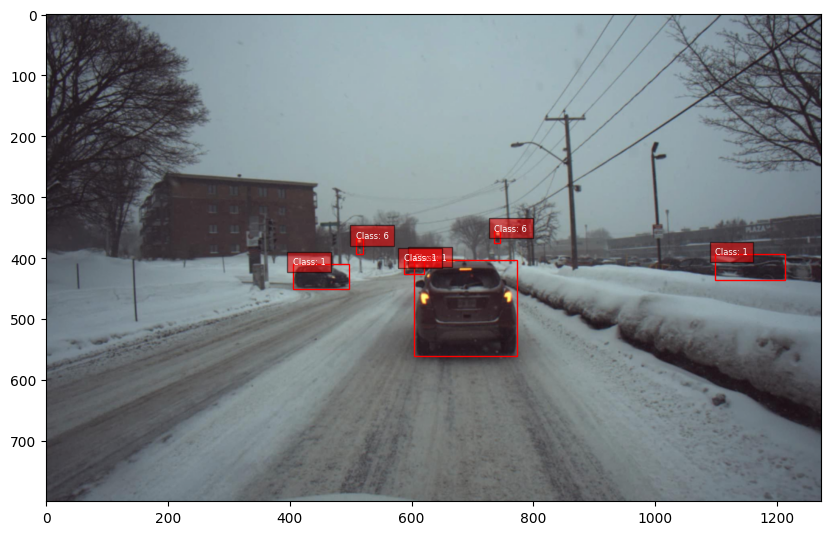

In [4]:
# DETR Image processor returns normalized YOLO format values ie [x_center, y_center, width, height] but in range [0, 1]
# So to get the actual values we need to multiply x_center and width by the image width and y_center and height by the image height => Gives absolute pixel values in YOLO format
def visualize_single_image(dataset, idx=0):
    """
    Visualize a single image from the dataset with bounding boxes
    
    Args:
        dataset: The dataset object
        idx: Index of the image to visualize
    """
    img, label = dataset[idx]
    
    # If the image is a tensor, convert to numpy
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
    
    # Denormalize if needed
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    # Draw bounding boxes
    if "boxes" in label:
        boxes = label["boxes"]
        if isinstance(boxes, torch.Tensor):
            boxes = boxes.numpy()
        img_h, img_w = 800, 1273
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            x1 = int(x1 * img_w)    # x_c
            y1 = int(y1 * img_h)    # y_c
            x2 = int(x2 * img_w)    # w
            y2 = int(y2 * img_h)    # h
            rect = plt.Rectangle((x1 - x2/2, y1 - y2/2), x2, y2, fill=False, edgecolor='red', linewidth=1)
            plt.gca().add_patch(rect)
            
            if "class_labels" in label:
                class_id = label["class_labels"][i]
                plt.text(x1 - x2/2, y1 - y2/2, f"Class: {class_id}", color='white', 
                         fontsize=6, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis()
    plt.show()

# Example usage:
visualize_single_image(test_dataset, idx=15)

# Training Loop for Model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision='no_timm', num_labels=len(id2label), ignore_mismatched_sizes=True)
model.to(DEVICE)

lr = 1e-4
lr_backbone = 1e-5

param_dicts = [ 
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
    {"params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
     "lr": lr_backbone}
]

optimizer = torch.optim.AdamW(param_dicts, lr=lr, weight_decay=1e-4)

best_train_loss = float("inf")

model.train()
for epoch in range(100):
    total_train_loss = 0

    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)
        labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_loader)

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        model_save_path = f"/kaggle/working/detr_r50_tuned.pth"
        torch.save(model.state_dict(), model_save_path)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {(epoch+1)} | Train Loss: {avg_train_loss:.4f}")

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 532/532 [29:07<00:00,  3.28s/it]


Epoch 10 | Train Loss: 2.4326


100%|██████████| 532/532 [27:29<00:00,  3.10s/it]


Epoch 20 | Train Loss: 2.1582


100%|██████████| 532/532 [27:25<00:00,  3.09s/it]


Epoch 30 | Train Loss: 2.0054


100%|██████████| 532/532 [27:31<00:00,  3.10s/it]


Epoch 40 | Train Loss: 1.8974


100%|██████████| 532/532 [27:27<00:00,  3.10s/it]


Epoch 50 | Train Loss: 1.8352


100%|██████████| 532/532 [27:25<00:00,  3.09s/it]


Epoch 60 | Train Loss: 1.7549


100%|██████████| 532/532 [27:07<00:00,  3.06s/it]


Epoch 70 | Train Loss: 1.7063


100%|██████████| 532/532 [27:04<00:00,  3.05s/it]


Epoch 80 | Train Loss: 1.6354


100%|██████████| 532/532 [27:08<00:00,  3.06s/it]


Epoch 90 | Train Loss: 1.9057


100%|██████████| 532/532 [27:13<00:00,  3.07s/it]

Epoch 100 | Train Loss: 2.0508


# Saving the Model Weights

In [ ]:
# After training is done, save the model weights
model_save_path = "/kaggle/working/detr_r_50_tuned.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /kaggle/working/detr_tuned.pth


# Loading the Saved Model

In [ ]:
# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision='no_timm', num_labels=len(id2label), ignore_mismatched_sizes=True)
# model_save_path = "/kaggle/working/detr_r50_tuned.pth"
# model.load_state_dict(torch.load(model_save_path))
# model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

# Code for Visualising Predictions and Calculating Precision, Recall and F1-Score

In [10]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis()
    plt.show()

In [ ]:
from collections import defaultdict

def calculate_iou(box1, box2):
    """
    Calculate intersection over union between two bounding boxes.
    Each box is [xmin, ymin, xmax, ymax]
    """
    # Ensure boxes are in the correct format
    if isinstance(box1, torch.Tensor):
        box1 = box1.tolist()
    if isinstance(box2, torch.Tensor):
        box2 = box2.tolist()
        
    # Calculate intersection coordinates
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    # Calculate area of intersection
    if x_max <= x_min or y_max <= y_min:
        return 0.0  # No intersection
    
    intersection_area = (x_max - x_min) * (y_max - y_min)
    
    # Calculate areas of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Calculate union area
    union_area = box1_area + box2_area - intersection_area
    
    # Return IoU
    return intersection_area / union_area

def evaluate_detections(predictions, ground_truths, iou_threshold=0.3):
    # Initialize counters
    total_tp = 0
    total_fp = 0
    total_fn = 0

    all_ious = []
    all_confidences = []
    
    # Per-class counters
    class_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    
    # Process each image
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']
        
        gt_boxes = gt['boxes']
        gt_labels = gt['labels']
        
        # Sort predictions by confidence score (highest first)
        sorted_indices = torch.argsort(pred_scores, descending=True)
        pred_boxes = pred_boxes[sorted_indices]
        pred_labels = pred_labels[sorted_indices]
        
        # Create a list to keep track of which GT boxes have been matched
        matched_gt = [False] * len(gt_boxes)
        
        # For each prediction
        for pred_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
            pred_label = pred_label.item()
            
            # Initialize best match
            best_iou = iou_threshold
            best_gt_idx = -1
            
            # Find the best matching ground truth box
            for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                gt_label = gt_label.item()
                
                # Skip if this GT has already been matched or labels don't match
                if matched_gt[gt_idx] or gt_label != pred_label:
                    continue
                
                # Calculate IoU
                iou = calculate_iou(pred_box.tolist(), gt_box.tolist())
                
                # Update best match if this is better
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            # If we found a match
            if best_gt_idx >= 0:
                # True positive
                total_tp += 1
                class_metrics[pred_label]['tp'] += 1
                matched_gt[best_gt_idx] = True
                all_ious.append(best_iou)
                all_confidences.append(pred_scores[pred_idx].item())
            else:
                # False positive
                total_fp += 1
                class_metrics[pred_label]['fp'] += 1
                all_confidences.append(pred_scores[pred_idx].item())
        
        # Count false negatives (GT boxes that weren't matched)
        for gt_idx, (matched, gt_label) in enumerate(zip(matched_gt, gt_labels)):
            gt_label = gt_label.item()
            if not matched:
                total_fn += 1
                class_metrics[gt_label]['fn'] += 1
    
    # Calculate overall metrics
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate per-class metrics
    per_class_metrics = {}
    for class_id, counts in class_metrics.items():
        class_precision = counts['tp'] / (counts['tp'] + counts['fp']) if (counts['tp'] + counts['fp']) > 0 else 0
        class_recall = counts['tp'] / (counts['tp'] + counts['fn']) if (counts['tp'] + counts['fn']) > 0 else 0
        class_f1 = 2 * class_precision * class_recall / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
        
        per_class_metrics[id2label[class_id]] = {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1
        }
    
    return {
        'overall': {
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'per_class': per_class_metrics,
        'ious': all_ious,
        'confidences': all_confidences
    }

# Plotting Predictions on Single Batch of Test Loader

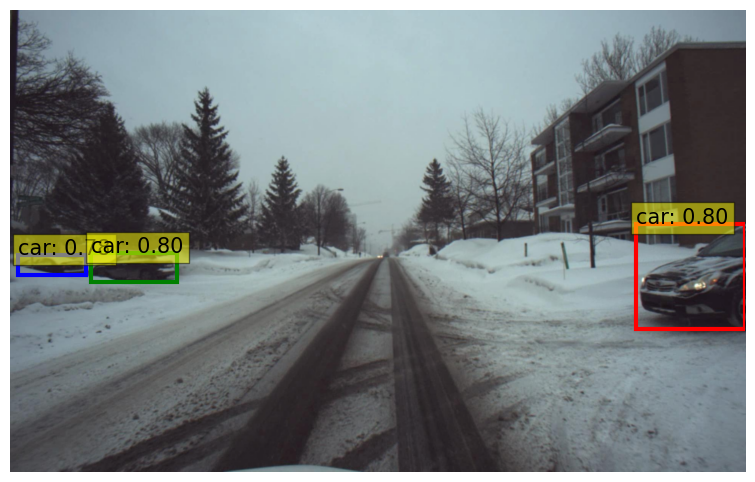

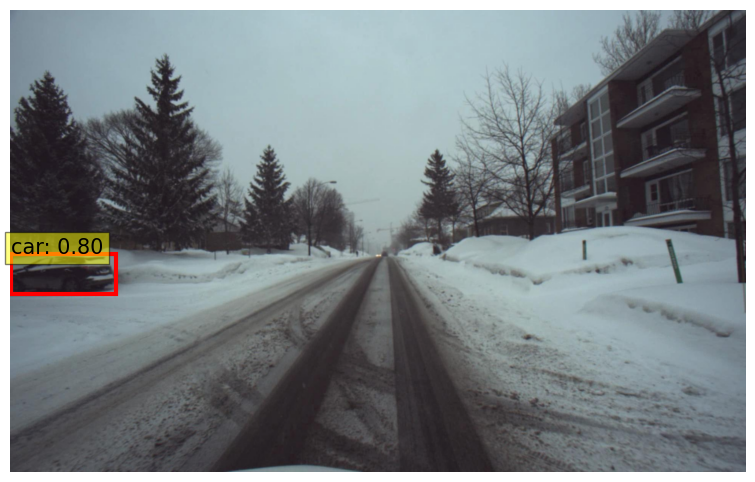

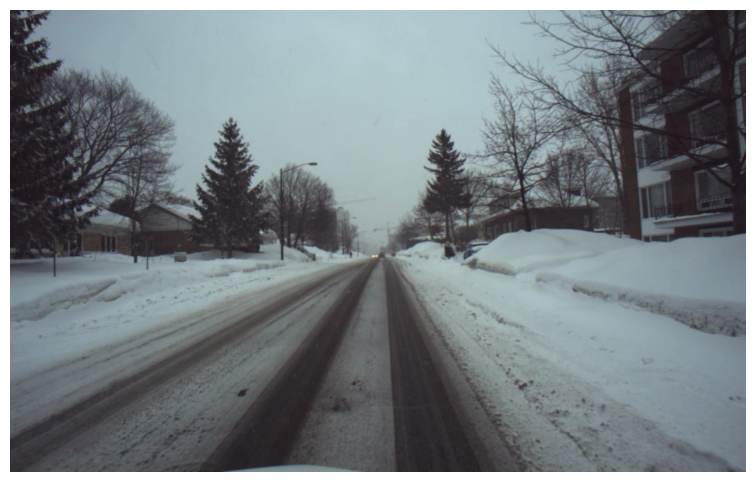

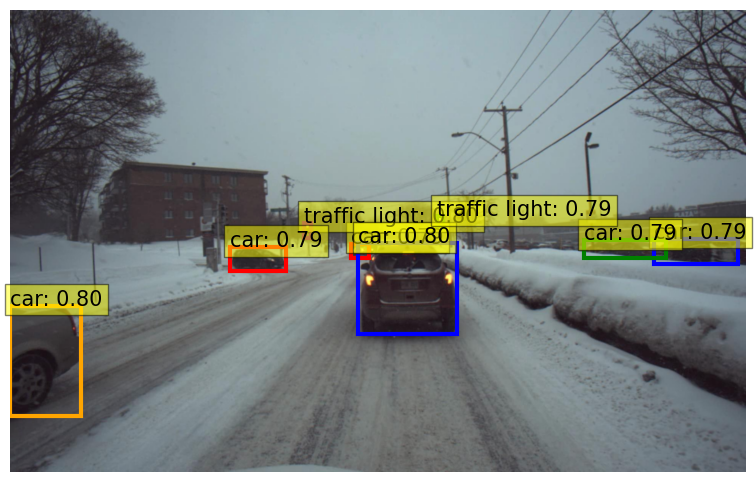

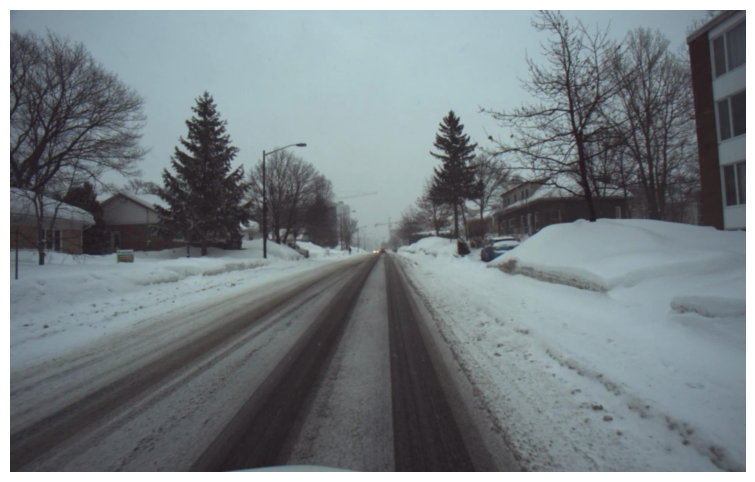

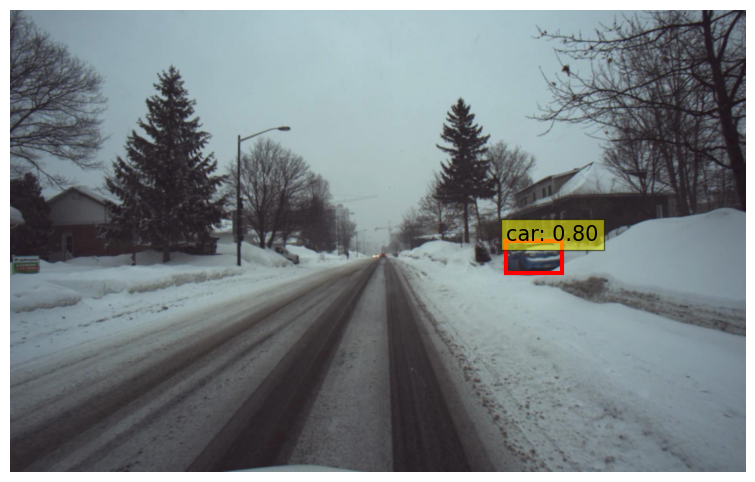

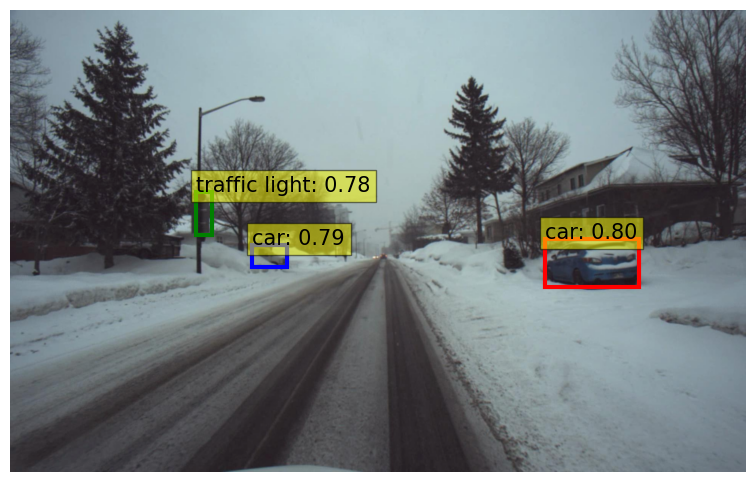

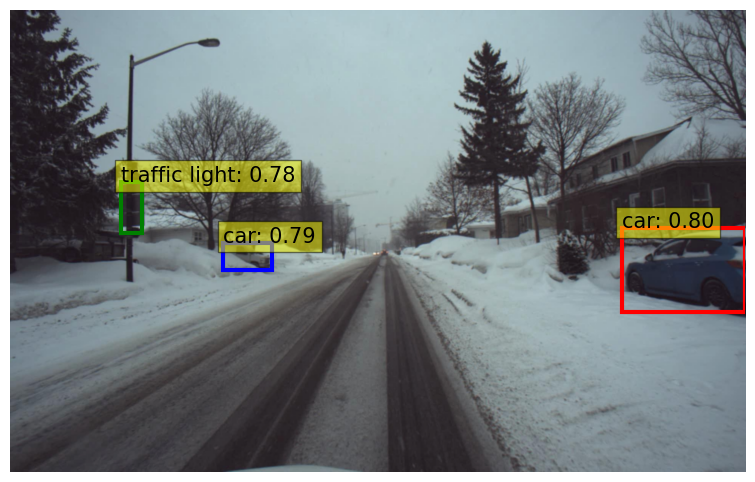

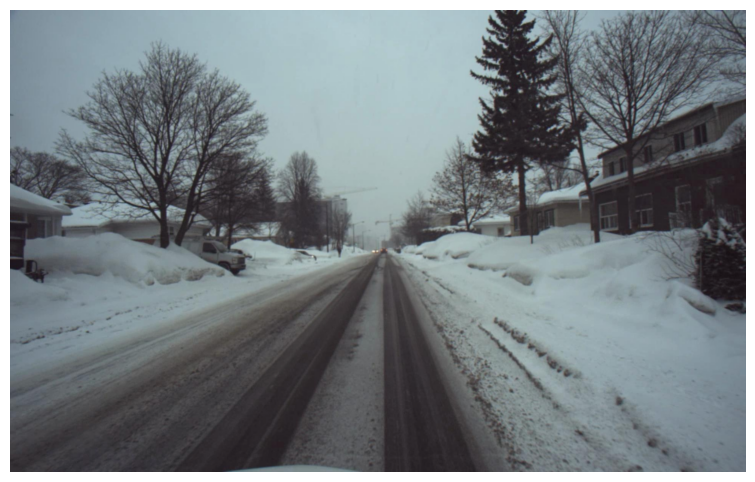

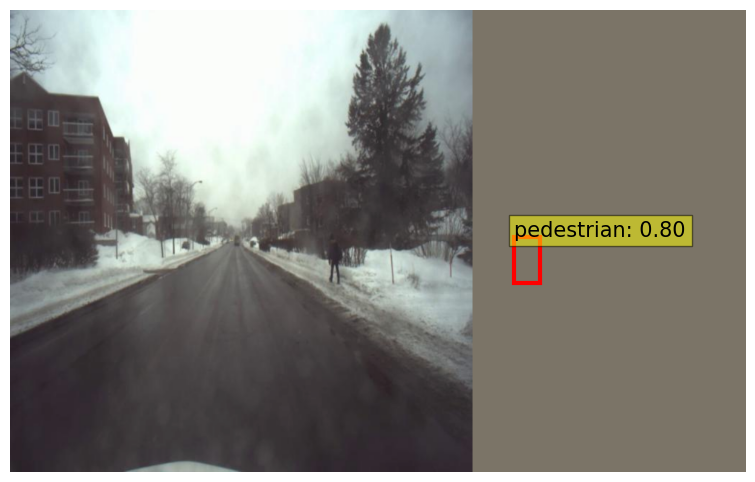

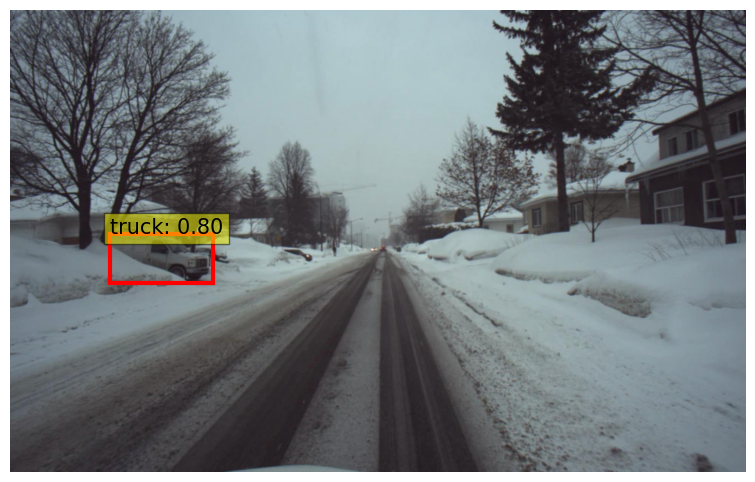

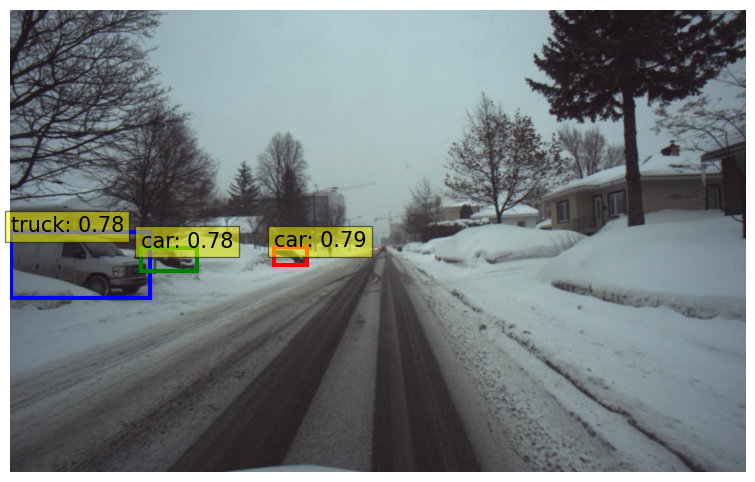

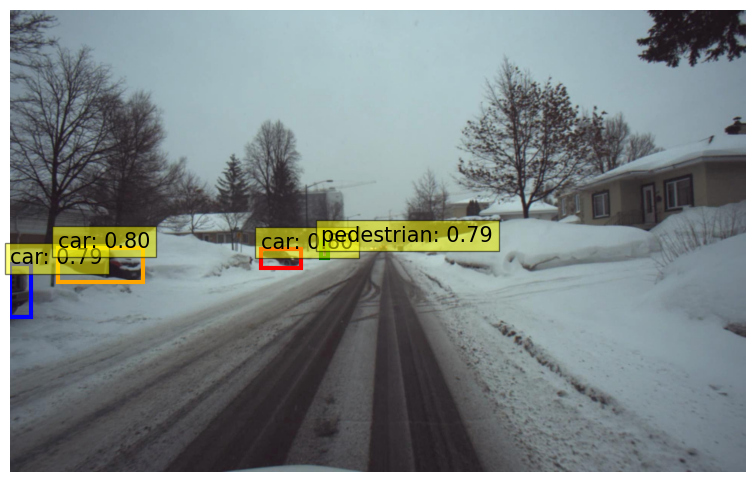

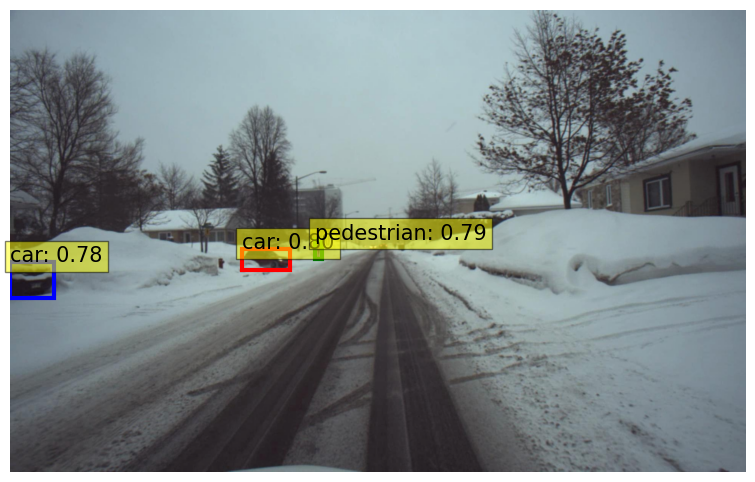

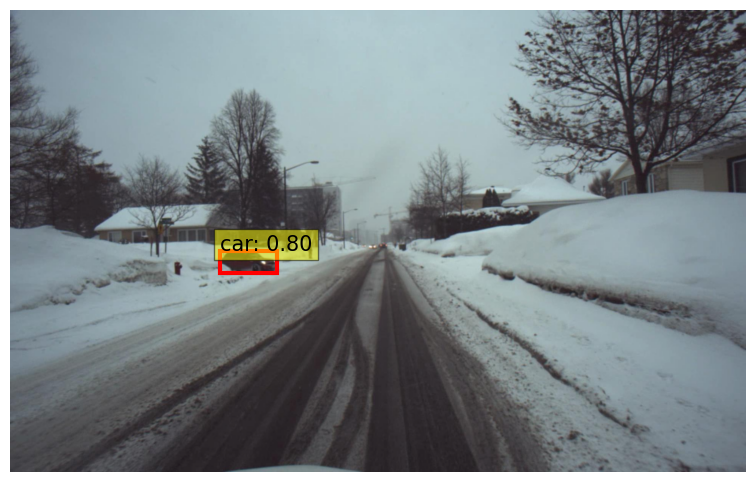

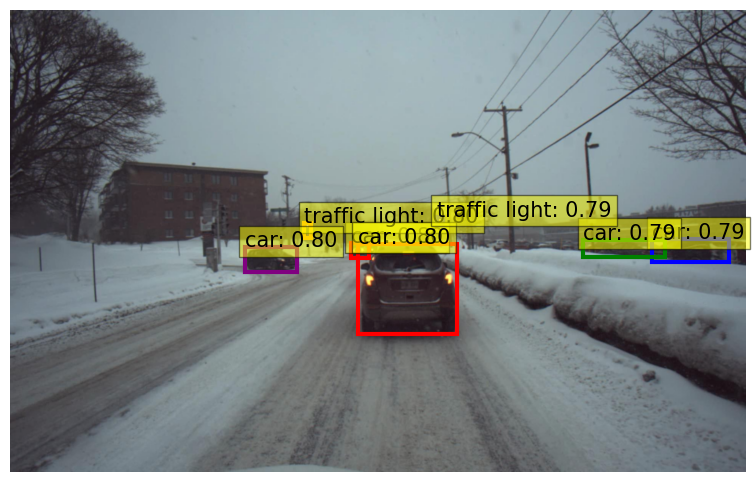


=== Object Detection Metrics ===
Overall Precision: 0.6485
Overall Recall: 0.5322
Overall F1 Score: 0.5846


In [ ]:
from torchvision.transforms.functional import to_pil_image

# Convert batch tensors back to images using normalization inverse if needed
# Since pixel_values were normalized before; this reverses ImageNet normalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).cuda()
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).cuda()

model.eval()
model.to(DEVICE)

# Plotting Predictions on a single batch
y = iter(test_loader)
batch = next(y)
pixel_values = batch["pixel_values"].to(DEVICE)
pixel_mask = batch["pixel_mask"].to(DEVICE)

# Run inference
with torch.no_grad():
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

images = pixel_values * std + mean  # unnormalize

# Convert to PIL images
pil_images = [to_pil_image(img.cpu()) for img in images]

# Post-process predictions
target_sizes = [img.size[::-1] for img in pil_images]
postprocessed_outputs = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.78)

# Plot each prediction
for img, result in zip(pil_images, postprocessed_outputs):
    scores = result["scores"]
    labels = result["labels"]
    boxes = result["boxes"]
    plot_results(img, scores, labels, boxes)

# Evaluating various metrics on Test Loader
all_predictions = []
all_ground_truths = []

for batch in tqdm(test_loader):
    pixel_values = batch["pixel_values"].cuda()
    pixel_mask = batch["pixel_mask"].cuda()

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # Unnormalize for image sizes
    images = pixel_values * std + mean
    pil_images = [to_pil_image(img.cpu()) for img in images]

    # Get original image sizes (height, width)
    target_sizes = [img.size[::-1] for img in pil_images]
    postprocessed_outputs = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.78)

    # Store predictions for all images in the batch
    all_predictions.extend(postprocessed_outputs)

    # Prepare ground truth boxes for each image in the batch
    for i in range(len(batch["labels"])):
        if "original_sizes" in batch['labels']:
            img_height, img_width = batch['labels'][i]["original_sizes"]
        else:
            img_width, img_height = pil_images[i].size

        gt_boxes = batch['labels'][i]["boxes"]
        absolute_boxes = []
        for box in gt_boxes:
            center_x, center_y, width, height = box

            abs_center_x = center_x * img_width
            abs_center_y = center_y * img_height
            abs_width = width * img_width
            abs_height = height * img_height

            xmin = abs_center_x - (abs_width / 2)
            ymin = abs_center_y - (abs_height / 2)
            xmax = abs_center_x + (abs_width / 2)
            ymax = abs_center_y + (abs_height / 2)

            absolute_boxes.append([xmin, ymin, xmax, ymax])

        gt = {
            "boxes": torch.tensor(absolute_boxes),
            "labels": batch["labels"][i]["class_labels"]
        }
        all_ground_truths.append(gt)

# Now evaluate on all collected predictions and ground truths
metrics = evaluate_detections(all_predictions, all_ground_truths)

# Print combined metrics
print("\n=== Object Detection Metrics ===")
print(f"Overall Precision: {metrics['overall']['precision']:.4f}")
print(f"Overall Recall: {metrics['overall']['recall']:.4f}")
print(f"Overall F1 Score: {metrics['overall']['f1']:.4f}")

### Code for Some Other Metrics & Graph Plots

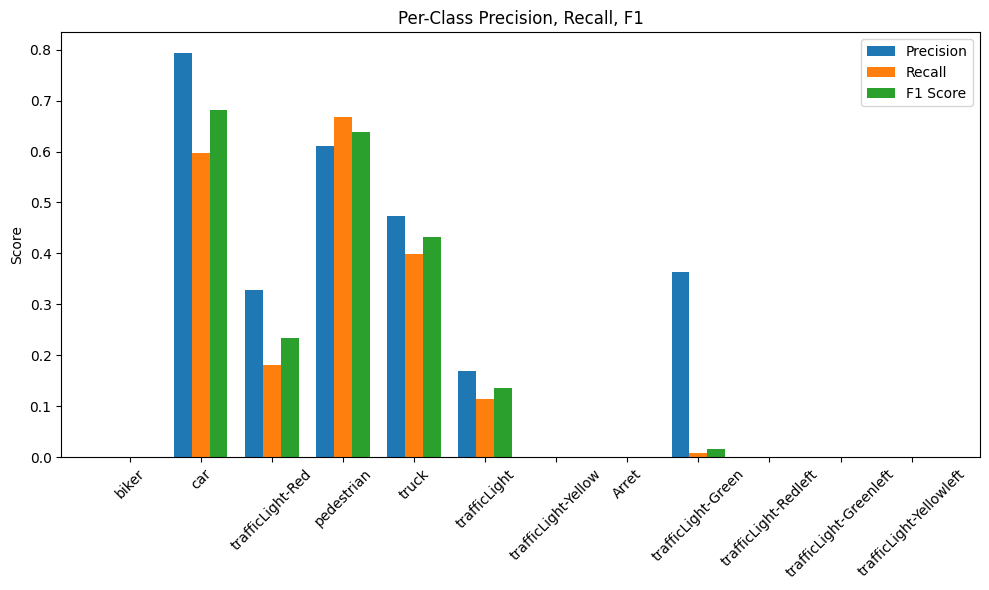

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


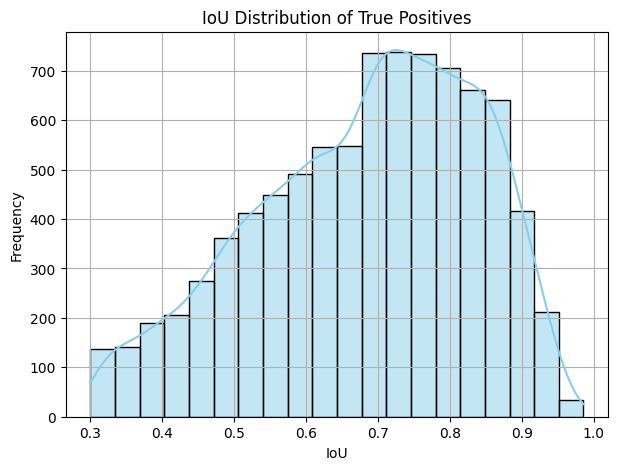

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


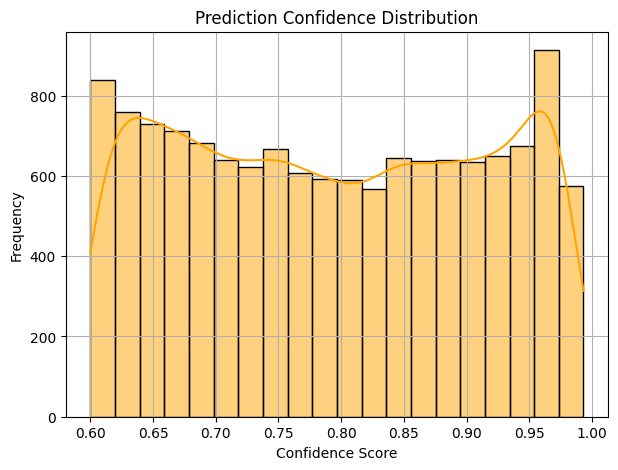

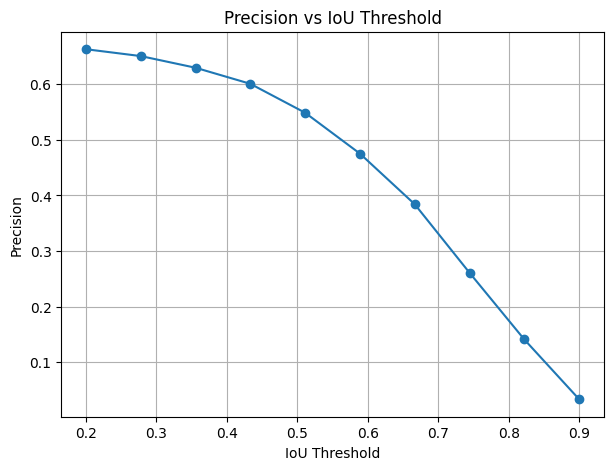

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_detection_metrics(metrics):
    # ===== 1. Per-Class Bar Chart =====
    class_names = list(metrics['per_class'].keys())
    precisions = [metrics['per_class'][cls]['precision'] for cls in class_names]
    recalls = [metrics['per_class'][cls]['recall'] for cls in class_names]
    f1_scores = [metrics['per_class'][cls]['f1'] for cls in class_names]

    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, precisions, width, label='Precision')
    plt.bar(x, recalls, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1 Score')
    plt.xticks(x, class_names, rotation=45)
    plt.ylabel('Score')
    plt.title('Per-Class Precision, Recall, F1')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===== 2. IoU Histogram =====
    if 'ious' in metrics:
        plt.figure(figsize=(7, 5))
        sns.histplot(metrics['ious'], bins=20, kde=True, color='skyblue')
        plt.xlabel('IoU')
        plt.ylabel('Frequency')
        plt.title('IoU Distribution of True Positives')
        plt.grid(True)
        plt.show()

    # ===== 3. Confidence Histogram =====
    if 'confidences' in metrics:
        plt.figure(figsize=(7, 5))
        sns.histplot(metrics['confidences'], bins=20, kde=True, color='orange')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.title('Prediction Confidence Distribution')
        plt.grid(True)
        plt.show()

    # ===== 4. Precision vs IoU Threshold Curve =====
    def precision_vs_iou(metrics, predictions, ground_truths, iou_thresholds=np.linspace(0.2, 0.9, 10)):
        precisions = []
        for iou_th in iou_thresholds:
            temp_metrics = evaluate_detections(predictions, ground_truths, iou_threshold=iou_th)
            precisions.append(temp_metrics['overall']['precision'])

        plt.figure(figsize=(7, 5))
        plt.plot(iou_thresholds, precisions, marker='o')
        plt.xlabel('IoU Threshold')
        plt.ylabel('Precision')
        plt.title('Precision vs IoU Threshold')
        plt.grid(True)
        plt.show()

    precision_vs_iou(metrics, all_predictions, all_ground_truths)

plot_detection_metrics(metrics)